In [1]:
#Import libraries
import torch
import os
import time
from datetime import datetime
from pytz import timezone
import copy
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
my_timezone = timezone('Chile/Continental')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from ae.train import TrainerAE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

#Training on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ",device)

selected:  cpu


In [2]:
#Arguments
class Args:
    batch_size = 128
    num_epochs = 5000
    lr = 1e-5
    patience = 200
    latent_dim = 32
    in_dim = 23686

args = Args()

In [3]:
#Dataset class
class CustomDataLoader(object):
    def __init__(self, data, ids):
        self.data = data
        self.ids = ids
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.ids[index]

In [4]:
#Build and return the train and test dataloaders
def get_data(path, batch_size):
    data = pd.read_csv(path, sep='\t', index_col=0).T
    ids = data.index.values
    
    #splitting train and test sets into 80%/20% respectively.
    x_train, x_test, ids_train, ids_test = train_test_split(data.values, ids, test_size=0.2, random_state=42)
    
    #generating dataloaders
    dataloader_train = DataLoader(CustomDataLoader(x_train, ids_train), batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(CustomDataLoader(x_test, ids_test), batch_size=batch_size, shuffle=False)
    return dataloader_train, dataloader_test

In [5]:
dataloader_train, dataloader_test = get_data(path='input_GenomicExample.txt', batch_size=args.batch_size)

In [6]:
start_time = time.time()
since = time.time()


ae = TrainerAE(args, dataloader_train, dataloader_test, device)
ae.train()
ae.load_weights()

print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training Autoencoder... Epoch: 0, Loss: 1.815
Testing Autoencoder... Epoch: 0, Loss: 1.79
Training Autoencoder... Epoch: 50, Loss: 1.749
Testing Autoencoder... Epoch: 50, Loss: 1.73
Training Autoencoder... Epoch: 100, Loss: 1.690
Testing Autoencoder... Epoch: 100, Loss: 1.69
Training Autoencoder... Epoch: 150, Loss: 1.636
Testing Autoencoder... Epoch: 150, Loss: 1.65
Training Autoencoder... Epoch: 200, Loss: 1.592
Testing Autoencoder... Epoch: 200, Loss: 1.62
Training Autoencoder... Epoch: 250, Loss: 1.567
Testing Autoencoder... Epoch: 250, Loss: 1.59
Training Autoencoder... Epoch: 300, Loss: 1.533
Testing Autoencoder... Epoch: 300, Loss: 1.56
Training Autoencoder... Epoch: 350, Loss: 1.510
Testing Autoencoder... Epoch: 350, Loss: 1.54
Training Autoencoder... Epoch: 400, Loss: 1.499
Testing Autoencoder... Epoch: 400, Loss: 1.52
Training Autoencoder... Epoch: 450, Loss: 1.477
Testing Autoencoder... Epoch: 450, Loss: 1.5
Training Autoencoder... Epoch: 500, Loss: 1.469
Testing Autoencoder

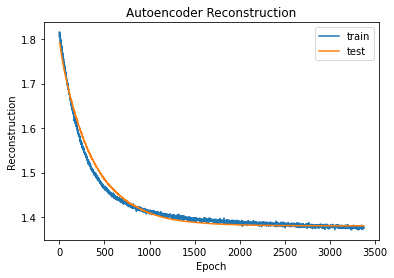

In [7]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, label='train')
    plt.plot(np.arange(len(values_t)), values_t, label='test')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')

plot_loss(np.array(ae.reconst), np.array(ae.reconst_t), 'Reconstruction')

In [8]:
def plot_latent_space(x_embedded, labels):
    plt.figure(figsize=(8,6))
    for label in np.unique(labels):
        plt.scatter(x_embedded[:, 0][labels==label], x_embedded[:, 1][labels==label], s=100, marker='.', label=label+1)
    plt.legend()
    plt.show()

In [9]:
ae.model.eval()
latent = []
for x, id_ in dataloader_train:
    x = x.float().to(device)
    z = ae.model.encode(x)
    latent.append(z.cpu().detach())

latent = torch.cat(latent)

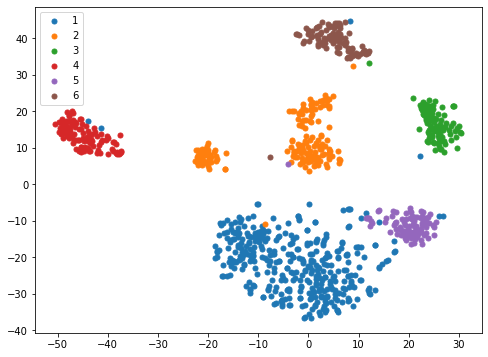

In [10]:
s_scores = []
c_labels = []
embeds = []

labels = AgglomerativeClustering(n_clusters=6, connectivity=None).fit_predict(latent)
x_embedded = TSNE(n_components=2).fit_transform(latent)
plot_latent_space(x_embedded, labels)
c_labels.append(labels)
embeds.append(x_embedded)